## Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime as dt
from scipy import stats

## Import CSV

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/online_retail_II.csv")
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


## Data Cleaning

In [ ]:
df_resik = df.copy()

# Create date column
df_resik['date'] = pd.to_datetime(df_resik['InvoiceDate']).dt.date

# Remove rows with missing Description
df_resik = df_resik[~df_resik['Description'].isna()].copy()

# Make all items in description column lowercase
df_resik['Description'] = df_resik['Description'].str.lower()

# Remove rows where Description is only digits or specific terms
df_resik = df_resik[~df_resik['Description'].str.match(r'^\d+$|^[pw]$|^postage$', case=False, na=False)].copy()

# Adding order status Column
# Assuming cancelled orders have invoice numbers starting with 'C'
df_resik['order_status'] = np.where(df_resik['Invoice'].astype(str).str.startswith('C'), 'Cancelled', 'Delivered')

# Make quantity positive
df_resik['Quantity'] = df_resik['Quantity'].abs()

# Remove rows with non-positive price
df_resik = df_resik[df_resik['Price'] > 0]

# Create new column by name amount
df_resik['Amount'] = df_resik['Quantity'] * df_resik['Price']

# Get the most common description for each stockcode
most_common_product_name = df_resik.groupby(['StockCode', 'Description'], as_index=False) \
.agg(order_cnt=('Invoice', 'nunique')).sort_values(['StockCode', 'order_cnt'], ascending=[True, False])
most_common_product_name = most_common_product_name.groupby('StockCode').head(1) \
.rename(columns={'Description': '_final_name'})[['StockCode', '_final_name']]

df_resik = df_resik.merge(
    most_common_product_name,
    how = 'left',
    on = 'StockCode'
)
df_resik['Description'] = df_resik['_final_name']
df_resik = df_resik.drop(columns=['_final_name'])

# Change Customer Id to String, handling NaN values
df_resik['Customer ID'] = df_resik['Customer ID'].astype(str).replace('\.0', '', regex=True).replace('nan', 'Unknown')

# Remove Outlier using Z-score
# Ensure that the columns used for z-score calculation do not contain NaN values

df_resik_cleaned = df_resik.dropna(subset=['Quantity', 'Amount']).copy()
z_scores = np.abs(stats.zscore(df_resik_cleaned[['Quantity', 'Amount']]))
df_resik_cleaned = df_resik_cleaned[(z_scores < 3).all(axis=1)].copy()


# Update df_resik with the rows after outlier removal
df_resik = df_resik_cleaned.reset_index(drop=True)
df_resik

<>:43: SyntaxWarning: invalid escape sequence '\.'
<>:43: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-1851185797.py:43: SyntaxWarning: invalid escape sequence '\.'
  df_resik['Customer ID'] = df_resik['Customer ID'].astype(str).replace('\.0', '', regex=True).replace('nan', 'Unknown')


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,date,order_status,Amount
0,489434,85048,15cm christmas glass ball 20 lights,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,2009-12-01,Delivered,83.40
1,489434,79323P,pink cherry lights,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009-12-01,Delivered,81.00
2,489434,79323W,white cherry lights,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009-12-01,Delivered,81.00
3,489434,22041,"record frame 7"" single size",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,2009-12-01,Delivered,100.80
4,489434,21232,strawberry ceramic trinket box,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,2009-12-01,Delivered,30.00
...,...,...,...,...,...,...,...,...,...,...,...
1057175,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680,France,2011-12-09,Delivered,10.20
1057176,581587,22899,children's apron dolly girl,6,2011-12-09 12:50:00,2.10,12680,France,2011-12-09,Delivered,12.60
1057177,581587,23254,childrens cutlery dolly girl,4,2011-12-09 12:50:00,4.15,12680,France,2011-12-09,Delivered,16.60
1057178,581587,23255,childrens cutlery circus parade,4,2011-12-09 12:50:00,4.15,12680,France,2011-12-09,Delivered,16.60


In [ ]:
df_resik_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1057180 entries, 0 to 1059048
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Invoice       1057180 non-null  object 
 1   StockCode     1057180 non-null  object 
 2   Description   1057180 non-null  object 
 3   Quantity      1057180 non-null  int64  
 4   InvoiceDate   1057180 non-null  object 
 5   Price         1057180 non-null  float64
 6   Customer ID   1057180 non-null  object 
 7   Country       1057180 non-null  object 
 8   date          1057180 non-null  object 
 9   order_status  1057180 non-null  object 
 10  Amount        1057180 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 96.8+ MB


## Data Visualization

Pivot Table

In [ ]:
pd.pivot_table(df_resik_cleaned, index='date',
               columns=['order_status'], values=['Invoice', 'Amount'],
               aggfunc={'Invoice': 'nunique',
                        'Amount' : np.sum},
               fill_value=0
)

/tmp/ipython-input-1447955835.py:1: FutureWarning: The provided callable <function sum at 0x7f043351cb80> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pd.pivot_table(df_resik_cleaned, index='date',


Amount             Invoice          
order_status Cancelled Delivered Cancelled Delivered
date                                                
2009-12-01     1330.89  52727.54        39       116
2009-12-02      570.92  59062.51        13       113
2009-12-03     2338.98  49454.91        14       120
2009-12-04      349.55  39500.87        12        88
2009-12-05        0.00   9803.05         0        30
...                ...       ...       ...       ...
2011-12-05      467.24  79444.43        13       125
2011-12-06     2480.34  53852.32        30       114
2011-12-07      362.94  52877.80        13       101
2011-12-08     1077.22  67073.04        20       118
2011-12-09      319.47  29644.66         4        43

[604 rows x 4 columns]

## Bar Chart

In [ ]:
df_summary = df_resik_cleaned.groupby('order_status', as_index=False).agg(order_cnt=('Invoice', 'nunique'), total_amount=('Amount', 'sum'))
df_summary

,order_status,order_cnt,total_amount
0,Cancelled,8003,5.090968e+05
1,Delivered,39581,1.861589e+07


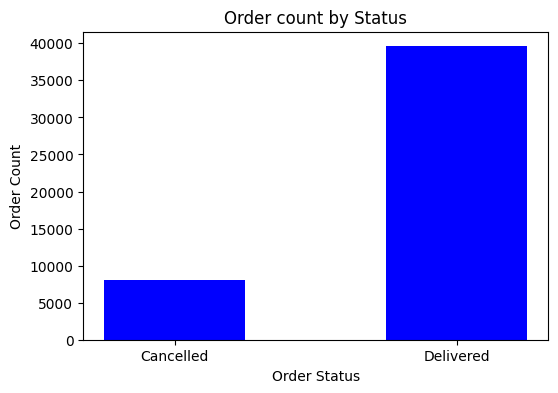

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.bar(df_summary['order_status'], df_summary['order_cnt'], color='blue', width=0.5)
plt.xlabel('Order Status')
plt.ylabel('Order Count')
plt.title('Order count by Status')
plt.show()

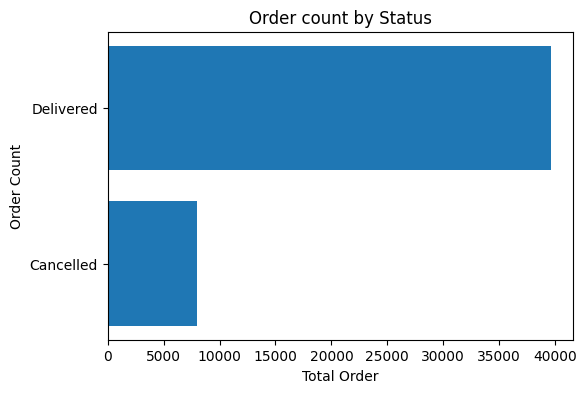

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.barh(df_summary['order_status'], df_summary['order_cnt'])
plt.xlabel('Total Order')
plt.ylabel('Order Count')
plt.title('Order count by Status')
plt.show()

## Histogram

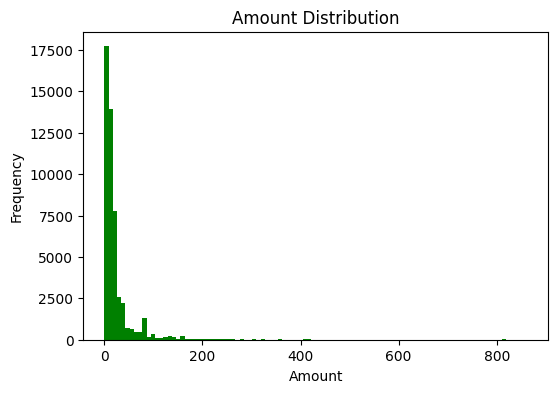

In [ ]:
# Histogram
fig = plt.figure(figsize=(6, 4))
plt.hist(df_resik_cleaned.loc[df_resik_cleaned['Description'].str.contains('light'), 'Amount'], 100, color='green')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Amount Distribution')
plt.show()

## LINE CHART

In [ ]:
df_date_summary = df_resik_cleaned.groupby('date', as_index=False).agg(order_cnt=('Invoice', 'nunique'), total_amount=('Amount', 'sum'))
df_date_summary

,date,order_cnt,total_amount
0,2009-12-01,155,54058.43
1,2009-12-02,126,59633.43
2,2009-12-03,134,51793.89
3,2009-12-04,100,39850.42
4,2009-12-05,30,9803.05
...,...,...,...
599,2011-12-05,138,79911.67
600,2011-12-06,144,56332.66
601,2011-12-07,114,53240.74
602,2011-12-08,138,68150.26


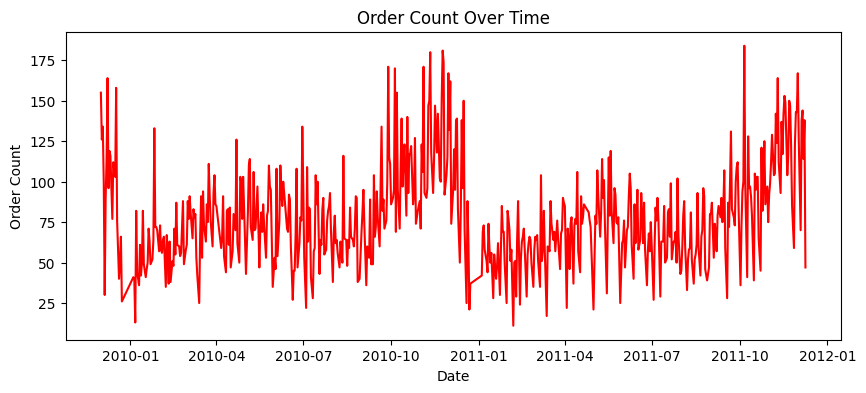

In [ ]:
fig = plt.figure(figsize=(10, 4))
plt.plot(df_date_summary['date'], df_date_summary['order_cnt'], color='red', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Order Count')
plt.title('Order Count Over Time')
plt.show()

## PIE CHART

In [ ]:
df_summary

,order_status,order_cnt,total_amount
0,Cancelled,8003,5.090968e+05
1,Delivered,39581,1.861589e+07


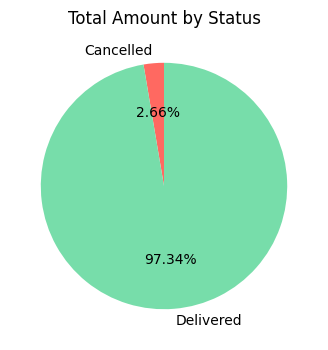

In [ ]:
fig = plt.figure(figsize=(5, 4))
plt.pie(df_summary['total_amount'], labels=df_summary['order_status'],
        autopct='%1.2f%%', startangle=90, colors=['#FF6961','#77DDAA'])
plt.title('Total Amount by Status')
plt.show()

## Scatter Plot

In [ ]:
def_light_only = df_resik_cleaned.loc[df_resik_cleaned['Description'].str.contains('light')]
def_light_only

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,date,order_status,Amount
0,489434,85048,15cm christmas glass ball 20 lights,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,2009-12-01,Delivered,83.40
1,489434,79323P,pink cherry lights,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009-12-01,Delivered,81.00
2,489434,79323W,white cherry lights,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009-12-01,Delivered,81.00
29,489436,84596L,biscuits small bowl light blue,8,2009-12-01 09:06:00,1.25,13078,United Kingdom,2009-12-01,Delivered,10.00
46,489437,84970S,hanging heart zinc t-light holder,12,2009-12-01 09:08:00,0.85,15362,United Kingdom,2009-12-01,Delivered,10.20
...,...,...,...,...,...,...,...,...,...,...,...
1059012,581585,22460,embossed glass tealight holder,12,2011-12-09 12:31:00,1.25,15804,United Kingdom,2011-12-09,Delivered,15.00
1059014,581585,23084,rabbit night light,12,2011-12-09 12:31:00,2.08,15804,United Kingdom,2011-12-09,Delivered,24.96
1059016,581585,84945,multi colour silver t-light holder,24,2011-12-09 12:31:00,0.85,15804,United Kingdom,2011-12-09,Delivered,20.40
1059028,581585,23145,zinc t-light holder star large,12,2011-12-09 12:31:00,0.95,15804,United Kingdom,2011-12-09,Delivered,11.40


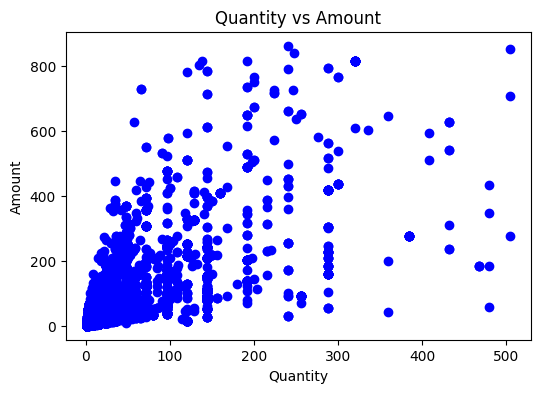

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.scatter(def_light_only['Quantity'], def_light_only['Amount'], color='blue', marker='o')
plt.xlabel('Quantity')
plt.ylabel('Amount')
plt.title('Quantity vs Amount')
plt.show()

## CORRELATION

<Axes: >

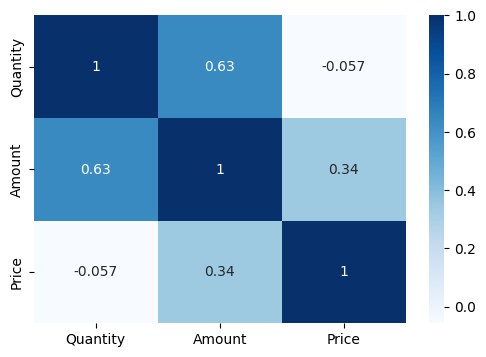

In [ ]:
# Correlation
plt.figure(figsize=(6, 4))
sns.heatmap(df_resik_cleaned[['Quantity', 'Amount', 'Price']].corr(), cmap='Blues', annot=True)